# ANN for Multi-Class Classification

Until now we have seen ANN in a regression setting. The loss function that we used for training was the MSE (Mean Squared Error). The standard loss function for multi-class classification is the Cross-Entropy Loss (also known as Log Loss) and first let's understand what it is.

## Entropy and Cross-Entropy

In evaluating a model's accuracy, we need a measure between our model's prediction and a perfect (out-of-sample) prediction. This measure should be able to account for the fact that some outcomes (targets) are easier to predict than others. Consider the task of predicting the weather (sunshine/rain) in a desert, where it almost never rains. A model that always predicts sunshine will be correct most of the time, but it is not a very useful model as you will always be surprised when it rains.

The *entropy* of a distribution is a measure of its uncertainty that has four properties

- It is **zero** if the distribution is degenerate (i.e. the outcome is always sunshine)
- It is **continuous**, so a small change in the distribution will result in a small change in the entropy
- It is **higher** for distributions which can produce **more outcomes** than for distributions that can produce fewer outcomes
- It is **additive**, so the entropy of a distribution is the sum of the entropies of its components. This means that if we first measure the uncertainty about being male/female and then measure the uncertainty about being a soccer fan or not, the uncertainty of the combinations (male/soccer fan, male/not soccer fan, female/soccer-fan, female/not soccer fan) should the sum of the two uncertainties.

It is easy to show that the entropy defined as the expected value of the log-probabilities of the outcomes satisfies these four properties.

$$
H(P) = -\sum_{k} p_k \log p_k
$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt


p0 = np.array([1])

p1 = np.array([1/2, 1/2])

p2 = np.array([1/5, 4/5])

p3 = np.array([1/3, 1/3, 1/3])

H_p0 = - np.sum(p0 * np.log(p0))
print(f"H_p0: {H_p0:.4f}")

H_p1 = - np.sum(p1 * np.log(p1))
print(f"H_p1: {H_p1:.4f}")

H_p2 = - np.sum(p2 * np.log(p2))
print(f"H_p2: {H_p2:.4f}")

H_p3 = - np.sum(p3 * np.log(p3))
print(f"H_p3: {H_p3:.4f}")

H_p0: -0.0000
H_p1: 0.6931
H_p2: 0.5004
H_p3: 1.0986


In [2]:
# Example with DEPENDENT variables
# Strong correlation: Soccer fans tend to be female

# Marginal distributions
p_female = 0.4
p_male = 1 - p_female
p_gender = np.array([p_male, p_female])

p_fan = 0.7
p_not_fan = 1 - p_fan
p_soccer = np.array([p_fan, p_not_fan])

# DEPENDENT joint distribution (not independent)
# Males: mostly NOT fans (90% not fans)
# Females: mostly fans (80% fans)
p_joint_dependent = np.array([
    0.06,   # Male & Fan (10% of 60%)
    0.54,   # Male & Not Fan (90% of 60%)
    0.32,   # Female & Fan (80% of 40%)
    0.08    # Female & Not Fan (20% of 40%)
])

p_joint_independent = np.array([
    p_male * p_fan,
    p_male * p_not_fan,
    p_female * p_fan,
    p_female * p_not_fan
])

def entropy(p):
    """Calculate entropy, handling zero probabilities"""
    p = p[p > 0]
    return -np.sum(p * np.log(p))

H_gender = entropy(p_gender)
H_soccer = entropy(p_soccer)
H_joint_dependent = entropy(p_joint_dependent)
H_joint_independent = entropy(p_joint_independent)

print(f"H(Gender) = {H_gender:.4f}")
print(f"H(Soccer Fan) = {H_soccer:.4f}")
print(f"H(Gender) + H(Soccer) = {H_gender + H_soccer:.4f}")
print(f"H(Gender, Soccer) (independent) = {H_joint_independent:.4f}")
print(f"H(Gender, Soccer) (dependent) = {H_joint_dependent:.4f}")

H(Gender) = 0.6730
H(Soccer Fan) = 0.6109
H(Gender) + H(Soccer) = 1.2839
H(Gender, Soccer) (independent) = 1.2839
H(Gender, Soccer) (dependent) = 1.0682


So the entropy gives us the uncertainty when predicting outcomes using the true distribution (in other words: how difficult it is to predict values from this distribution). When we build prediction models, however, we don't know the distribution generating the outcomes. Instead, we rely on the model to provide probabilities that we hope are close to the true probabilities. 

We can ask: how much does the uncertainty increase if we use a different (from P) distribution  instead of the true probabilities to predict the outcomes? This is the *cross-entropy*.

$$
H(P, Q) = -\sum_{k} p_k \log q_k
$$

It can also be decomposed into the entropy of the true distribution and the Kullback-Leibler divergence between the true distribution and the model distribution.

$$
H(P, Q) = H(P) + \text{KL}(P, Q)
$$

In the above expression, H(p) is the entropy of the data-generating distribution, and KL(p, q) is the Kullback-Leibler divergence between the data-generating distribution and the model distribution. The KL divergence is always non-negative, and it is zero if the two distributions are identical. Therefore, the cross-entropy is always greater than or equal to the entropy of the data-generating distribution.

$$
\text{KL}(P, Q) = \sum_{k} p_k (\log p_k - \log q_k) = \sum_{i} p_k \log \frac{p_k}{q_k}
$$

The KL-divergence describes how different P and Q are on average (in units of entropy). You have likely encountered a scaled version of it when studying generalized linear models (GLM) under the name of *deviance*. The deviance is the KL-divergence between the data-generating distribution and the model distribution, scaled by a factor of two.  

In gradient descent, we want to minimize the cross-entropy between the true distribution (the labels) and the model distribution (the predicted probabilities). The loss function for multi-class logistic regression is the cross-entropy loss:

In [3]:
# Difficulty predicting outcomes from P using Q

P_true = np.array([0.7, 0.3])  # True distribution
Q_model1 = np.array([0.4, 0.6])  # Model's predicted distribution
Q_model2 = np.array([0.75, 0.25])  # Another model's predicted distribution

H_P = -np.sum(P_true * np.log(P_true))
H_P_Q1 = -np.sum(P_true * np.log(Q_model1))
H_P_Q2 = -np.sum(P_true * np.log(Q_model2))

print(f"Entropy H(P) = {H_P:.4f}")
print(f"Cross-Entropy H(P, Q1) = {H_P_Q1:.4f}")
print(f"Cross-Entropy H(P, Q2) = {H_P_Q2:.4f}")

Entropy H(P) = 0.6109
Cross-Entropy H(P, Q1) = 0.7947
Cross-Entropy H(P, Q2) = 0.6173



:::{#def-cross-entropy-loss}
## Cross-Entropy Loss

Given $K$ classes and $n$ observations, the cross-entropy loss for multiclass logistic regression is given by

$$
\text{CE}(w) = -\sum_{i=1}^n \sum_{k=1}^K y_{ik} \log \hat{y}_{ik}
$$

Each $y_{ik}$ is an indicator function that is 1 if observation $i$ belongs to class $k$ and 0 otherwise, and $\hat{y}_{ik}$ is the predicted probability that observation $i$ belongs to class $k$.

:::



Consider the following example to illustrate the loss computation. Let's say that we have three classes (A, B, C) and the true labels for four observations are as follows:

| Observation | True Class |
|-------------|------------|
| 1           | A          |
| 2           | C          |
| 3           | B          |
| 4           | A          |

The one-hot encoded representation of the true labels is:

$$\hat{y}_1 = \frac{e^{o_1}}{e^{o_1} +e^{o_2} + e^{o_3}}$$

In [4]:
# One hot-encoded vectors for the true labels

true_labels = np.array([
    [1, 0, 0],  # Observation 1: Class A
    [0, 0, 1],  # Observation 2: Class C
    [0, 1, 0],  # Observation 3: Class B
    [1, 0, 0]   # Observation 4: Class A
])

# Predicted probabilities from the model

predicted_probs = np.array([
    [0.7, 0.2, 0.1],  # Observation 1
    [0.1, 0.3, 0.6],  # Observation 2
    [0.2, 0.5, 0.3],  # Observation 3
    [0.6, 0.3, 0.1]   # Observation 4
])

# Calculate cross-entropy loss

# First observation:

cross_entropy_obs1 = -np.sum(true_labels[0] * np.log(predicted_probs[0]))
print(f"Cross-Entropy Loss for Observation 1: {cross_entropy_obs1:.4f}")

# All observations:
cross_entropy_all = -np.sum(true_labels * np.log(predicted_probs))
print(f"Total Cross-Entropy Loss for All Observations: {cross_entropy_all:.4f}")

Cross-Entropy Loss for Observation 1: 0.3567
Total Cross-Entropy Loss for All Observations: 2.0715


## Binary Classification

In binary classification, we have only two classes (0 and 1), e.g. default/not default, male/female, yes/no, etc. When making predictions we want our model to output a single probability $\hat{y}$ for class 1, and the probability for class 0 is $1 - \hat{y}$.

We can adapt the network for linear regression for binary classification by passing the output of the network through a **sigmoid** function that maps any real-valued number into the (0, 1) interval, making it suitable for representing probabilities.

In addition we also need to change the loss function from MSE to cross-entropy loss for binary classification.

### Binary Cross-Entropy Loss

The cross-entropy loss for binary classification is known as **binary cross-entropy** (BCE) or log loss.

$$
\text{BCE}(y,\hat{y}) = -\,y \log \hat{y}\;-\;(1-y)\log(1-\hat{y})
$$


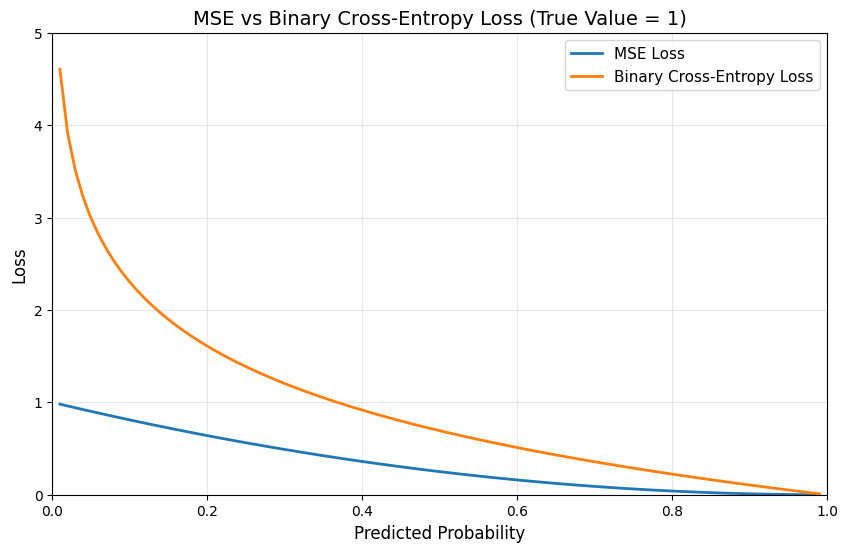

In [5]:
# Create range of predicted probabilities
p_hat = np.linspace(0.01, 0.99, 100)

# True value
y_true = 1

# Calculate MSE loss for binary classification (true value = 1)
mse_loss = (y_true - p_hat) ** 2

# Calculate Binary Cross-Entropy loss (true value = 1)
# BCE = -y*log(p_hat) - (1-y)*log(1-p_hat)
# When y=1: BCE = -log(p_hat)
bce_loss = -np.log(p_hat)

# Plot both losses
plt.figure(figsize=(10, 6))
plt.plot(p_hat, mse_loss, label='MSE Loss', linewidth=2)
plt.plot(p_hat, bce_loss, label='Binary Cross-Entropy Loss', linewidth=2)
plt.xlabel('Predicted Probability', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('MSE vs Binary Cross-Entropy Loss (True Value = 1)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, 5)
plt.show()

So with these two changes the network prediction and loss function for binary classification become:

$$
\begin{align*}
\hat{y} & = \sigma(l) = \frac{e^{l}}{1 + e^{l}} \\
l & =  w_1 x_1 + w_2 x_2 + ... + w_p x_p + b = X W  + b \\
\text{BCE}(y,\hat{y}) & = -\,y \log \hat{y}\;-\;(1-y)\log(1-\hat{y})
\end{align*}
$$

where $l$ is the output of the network before applying the sigmoid function (also known as the logit).


![Binary Classification with ANN](./figures/ann/Binary-Logistic-Regression-Head.png)

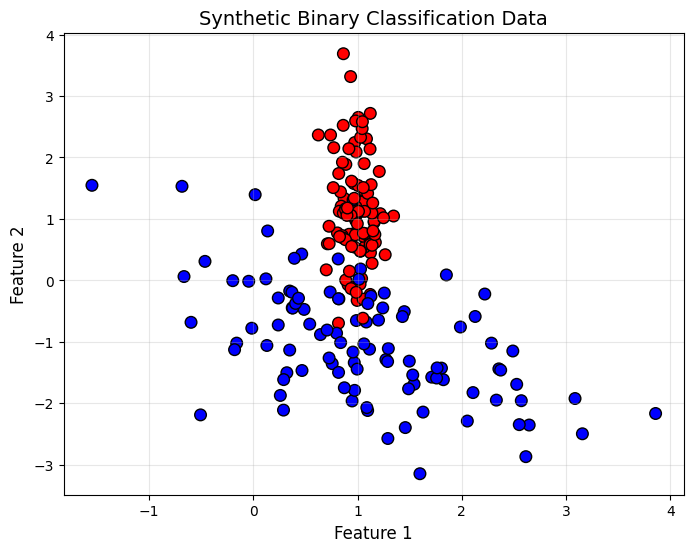

In [6]:
from sklearn.datasets import make_classification

# Generate synthetic binary classification data
X, y = make_classification(n_samples=200, n_features=2, n_informative=2, 
                           n_redundant=0, n_clusters_per_class=1, 
                           random_state=13)

# Plot the data
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolor='k', s=70)
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Feature 2', fontsize=12)
plt.title('Synthetic Binary Classification Data', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()


Epoch [100/1000], Loss: 0.2631
Epoch [200/1000], Loss: 0.1769
Epoch [300/1000], Loss: 0.1480
Epoch [400/1000], Loss: 0.1367
Epoch [500/1000], Loss: 0.1312
Epoch [600/1000], Loss: 0.1272
Epoch [700/1000], Loss: 0.1233
Epoch [800/1000], Loss: 0.1221
Epoch [900/1000], Loss: 0.1215
Epoch [1000/1000], Loss: 0.1212


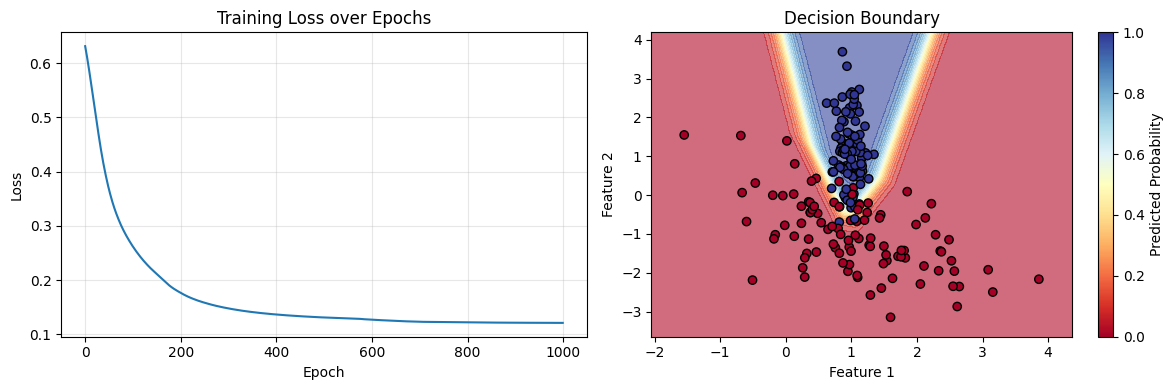

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y).reshape(-1, 1)

# Define a simple neural network for binary classification
class BinaryClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=4):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)        
        self.fc2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Initialize model
model = BinaryClassifier(input_size=2, hidden_size=3)

# Then the loss function and the optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 1000
losses = []

for epoch in range(epochs):
    # Forward pass
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Plot training loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True, alpha=0.3)

# Plot decision boundary
plt.subplot(1, 2, 2)
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))
grid = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
with torch.no_grad():
    Z = model(grid).numpy().reshape(xx.shape)

plt.contourf(xx, yy, Z, levels=20, cmap='RdYlBu', alpha=0.6)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdYlBu', edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Boundary')
plt.colorbar(label='Predicted Probability')
plt.tight_layout()
plt.show()

## Multi-Class Classification with ANN

When we need to predict more than two classes (e.g. nationality, type of disease, species of an animal, etc., credit risk level: low/medium/high), we can extend the binary classification ANN by adding as many output nodes as the number of classes. Just as we used the sigmoid function to squash the logits into probabilities, we can achieve the same for multi-class classification using the **softmax** function.

$$
\hat{y}_k = \frac{e^{o_k}}{\sum_{j=1}^K e^{o_j}}
$$


In [8]:
logits = np.array([2.0, 1.0, -3])

exp_logits = np.exp(logits)
softmax_probs = exp_logits / np.sum(exp_logits)

print("Logits:", logits)
print("Exponentiated Logits:", exp_logits)
print("Softmax Probabilities:", softmax_probs)

print("Sum of Softmax Probabilities:", np.sum(softmax_probs))

Logits: [ 2.  1. -3.]
Exponentiated Logits: [7.3890561  2.71828183 0.04978707]
Softmax Probabilities: [0.72747516 0.26762315 0.00490169]
Sum of Softmax Probabilities: 1.0


<img src="./figures/ann/Multiclass-Classification-Head.png" alt="Multiclass-Softmax" width="600" />

Where $l_1, l_2, l_3$ are the output logits for classes A, B, and C respectively.

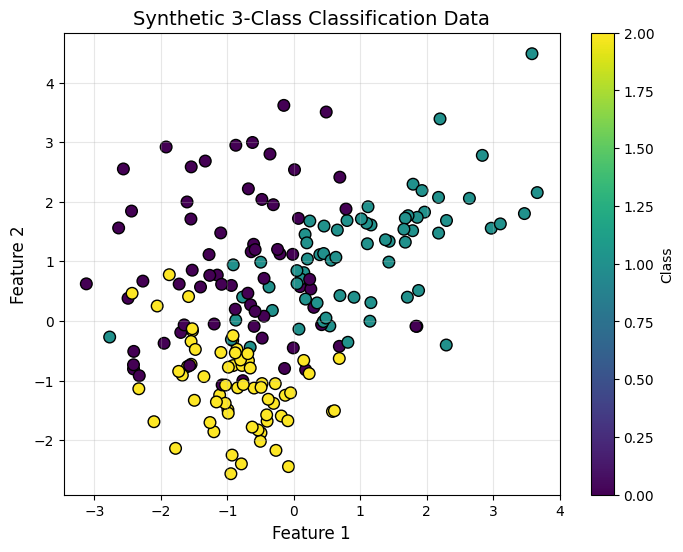

In [9]:
from sklearn.datasets import make_classification

# Generate synthetic data for 3-class classification

X_multi, y_multi = make_classification(n_samples=200, n_features=2, n_informative=2,
                                       n_redundant=0, n_clusters_per_class=1,
                                       n_classes=3, random_state=42)

# Plot the data
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_multi[:, 0], X_multi[:, 1], c=y_multi, cmap='viridis', 
                     edgecolor='k', s=70)
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Feature 2', fontsize=12)
plt.title('Synthetic 3-Class Classification Data', fontsize=14)
plt.colorbar(scatter, label='Class')
plt.grid(True, alpha=0.3)
plt.show()


In [10]:
X_multi

array([[-0.37217607,  0.56938167],
       [-0.14989682,  3.61729861],
       [-0.40131003, -1.6824895 ],
       [ 3.66332221,  2.15367981],
       [ 0.16991891,  1.45195312],
       [ 2.20050588,  3.39033529],
       [-1.52430341, -0.16562994],
       [-1.54547705, -0.34450731],
       [-0.44758139,  0.71376284],
       [ 1.85205111, -0.09118106],
       [-0.30355816, -1.38366201],
       [-1.9208928 ,  2.9189499 ],
       [ 0.48806269,  3.50578584],
       [-1.70056309, -0.19333846],
       [-0.20876699,  1.12654681],
       [-1.20253167, -1.86018763],
       [-0.74191157, -0.68014175],
       [-0.24392415,  1.19979806],
       [-1.40349166,  0.5694988 ],
       [-0.76965593,  0.40081602],
       [-0.91981512, -0.32833499],
       [ 0.90679809,  0.39705295],
       [-0.47995197,  2.03891075],
       [ 0.19586869,  1.3104516 ],
       [-3.12190908,  0.62220145],
       [-0.64962646,  0.27033822],
       [-1.11578941, -1.2429851 ],
       [-2.41167954, -0.80620914],
       [ 1.96734507,

In [11]:
y_multi

array([1, 0, 2, 1, 1, 1, 2, 2, 0, 1, 2, 0, 0, 0, 0, 2, 2, 0, 0, 1, 2, 1,
       0, 1, 0, 0, 2, 0, 1, 0, 0, 1, 1, 1, 2, 0, 0, 2, 0, 0, 0, 1, 2, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 2, 2, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 2, 1, 0, 2, 0, 2, 2, 2, 0, 2, 1, 2, 1,
       2, 1, 2, 1, 0, 1, 2, 1, 0, 1, 0, 2, 2, 0, 1, 2, 0, 2, 2, 2, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 2, 2, 1, 1, 1, 2, 2, 0, 1, 2, 2,
       1, 0, 1, 2, 2, 2, 2, 2, 2, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 1, 0, 2, 2, 2, 1, 2, 1, 1, 0, 0, 0, 1, 2, 2, 2, 0, 2, 2, 2,
       0, 2, 1, 0, 0, 2, 2, 0, 1, 2, 0, 2, 2, 1, 0, 2, 2, 2, 0, 0, 1, 2,
       1, 2])

Epoch [200/2500], Loss: 0.5297
Epoch [400/2500], Loss: 0.5128
Epoch [600/2500], Loss: 0.5103
Epoch [800/2500], Loss: 0.5100
Epoch [1000/2500], Loss: 0.5099
Epoch [1200/2500], Loss: 0.5099
Epoch [1400/2500], Loss: 0.5099
Epoch [1600/2500], Loss: 0.5099
Epoch [1800/2500], Loss: 0.5099
Epoch [2000/2500], Loss: 0.5099
Epoch [2200/2500], Loss: 0.5099
Epoch [2400/2500], Loss: 0.5099


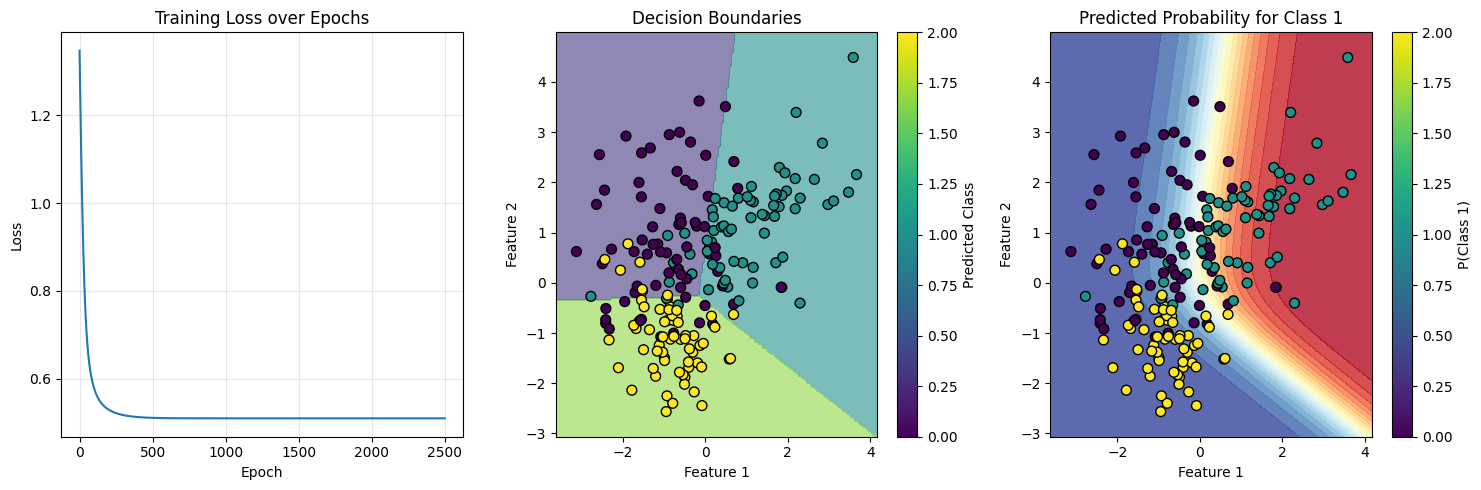


Training Accuracy: 0.8050


In [12]:

# Convert to PyTorch tensors
X_multi_tensor = torch.FloatTensor(X_multi)
y_multi_tensor = torch.LongTensor(y_multi)  # Note: LongTensor for class indices

# Define neural network for multi-class classification

class MultiClassClassifier(nn.Module):    
    def __init__(self, input_size, num_classes):
        super(MultiClassClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, num_classes)
        # self.fc2 = nn.Linear(hidden_size, num_classes)
        # No softmax here - CrossEntropyLoss applies it internally
        
    def forward(self, x):
        x = self.fc1(x)
        # x = torch.relu(x)
        # x = self.fc2(x)  # Output logits
        return x

# Initialize model
model_multi = MultiClassClassifier(input_size=2, num_classes=3)
# CrossEntropyLoss combines LogSoftmax and NLLLoss
criterion_multi = nn.CrossEntropyLoss()
optimizer_multi = optim.Adam(model_multi.parameters(), lr=0.01)

# Training loop
epochs_multi = 2500
losses_multi = []

for epoch in range(epochs_multi):
    # Forward pass
    y_pred = model_multi(X_multi_tensor)
    loss_multi = criterion_multi(y_pred, y_multi_tensor)
    
    # Backward pass and optimization
    optimizer_multi.zero_grad()
    loss_multi.backward()
    optimizer_multi.step()
    
    losses_multi.append(loss_multi.item())
    
    if (epoch + 1) % 200 == 0:
        print(f'Epoch [{epoch+1}/{epochs_multi}], Loss: {loss_multi.item():.4f}')

# Plot training loss and decision boundaries
plt.figure(figsize=(15, 5))

# Training loss
plt.subplot(1, 3, 1)
plt.plot(losses_multi)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True, alpha=0.3)

# Decision boundary
plt.subplot(1, 3, 2)
x_min_multi, x_max_multi = X_multi[:, 0].min() - 0.5, X_multi[:, 0].max() + 0.5
y_min_multi, y_max_multi = X_multi[:, 1].min() - 0.5, X_multi[:, 1].max() + 0.5
xx_multi, yy_multi = np.meshgrid(np.linspace(x_min_multi, x_max_multi, 200),
                                  np.linspace(y_min_multi, y_max_multi, 200))
grid_multi = torch.FloatTensor(np.c_[xx_multi.ravel(), yy_multi.ravel()])

with torch.no_grad():
    logits_multi = model_multi(grid_multi)
    probs_multi = torch.softmax(logits_multi, dim=1)
    predictions = torch.argmax(probs_multi, dim=1).numpy().reshape(xx_multi.shape)

plt.contourf(xx_multi, yy_multi, predictions, levels=2, cmap='viridis', alpha=0.6)
plt.scatter(X_multi[:, 0], X_multi[:, 1], c=y_multi, cmap='viridis', edgecolors='k', s=50)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Boundaries')
plt.colorbar(label='Predicted Class')

# Predicted probabilities for each class
plt.subplot(1, 3, 3)
with torch.no_grad():
    probs_class_1 = probs_multi[:, 1].numpy().reshape(xx_multi.shape)
plt.contourf(xx_multi, yy_multi, probs_class_1, levels=20, cmap='RdYlBu_r', alpha=0.8)
plt.scatter(X_multi[:, 0], X_multi[:, 1], c=y_multi, cmap='viridis', edgecolors='k', s=50)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Predicted Probability for Class 1')
plt.colorbar(label='P(Class 1)')

plt.tight_layout()
plt.show()

# Print accuracy
with torch.no_grad():
    predictions_train = torch.argmax(torch.softmax(model_multi(X_multi_tensor), dim=1), dim=1)
    accuracy = (predictions_train == y_multi_tensor).float().mean()
    print(f'\nTraining Accuracy: {accuracy.item():.4f}')

In [13]:
# Show the learned weights

for name, param in model_multi.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.data.numpy()}")

fc1.weight: [[-1.4592453   1.2041762 ]
 [ 0.32818967  0.9001562 ]
 [-1.370656   -1.7053242 ]]
fc1.bias: [ 0.25732914  0.49220163 -0.45520714]


In [14]:
# Predict a new sample
new_sample = np.array([[0.5, -1.0]]).reshape(1, -1)
new_sample_tensor = torch.FloatTensor(new_sample)

print(f'New Sample: {new_sample_tensor.numpy()}')

with torch.no_grad():
    logits_new = model_multi(new_sample_tensor)
    print(f'Logits for New Sample: {logits_new.numpy()}')

    probs_new = torch.softmax(logits_new, dim=1)
    predicted_class = torch.argmax(probs_new, dim=1).item()
    
    print(f'Predicted Class: {predicted_class}, Probabilities: {probs_new.numpy()}')

New Sample: [[ 0.5 -1. ]]
Logits for New Sample: [[-1.6764697  -0.24385971  0.56478906]]
Predicted Class: 2, Probabilities: [[0.06851764 0.28706282 0.6444195 ]]


In [15]:
# Manually reproduce the softmax calculation for the new sample using the learned weights

W = model_multi.fc1.weight.data.numpy()
b = model_multi.fc1.bias.data.numpy()
logits_manual = new_sample @ W.T + b
exp_logits_manual = np.exp(logits_manual)
print("Manual Logits:", logits_manual)
print("Manual Exponentiated Logits:", exp_logits_manual)
softmax_manual = exp_logits_manual / np.sum(exp_logits_manual)
print("Manual Softmax Probabilities:", softmax_manual)

Manual Logits: [[-1.67646971 -0.24385974  0.56478903]]
Manual Exponentiated Logits: [[0.18703309 0.78359754 1.75907663]]
Manual Softmax Probabilities: [[0.06851764 0.28706285 0.64441952]]


## Softmax reduces to Sigmoid for two classes

For two logits $l_1, l_2$:

$$
\text{softmax}(l_1) = \frac{e^{l_1}}{e^{l_1}+e^{l_2}},\quad
\text{softmax}(l_2) = \frac{e^{l_2}}{e^{l_1}+e^{l_2}}
$$

Divide numerator and denominator of $\text{softmax}(l_2)$ by $e^{l_1}$:

$$
\text{softmax}(l_2)
= \frac{e^{l_2-l_1}}{1 + e^{l_2-l_1}}
= \sigma(l_2 - l_1)
$$

where $\sigma(x) = \frac{1}{1 + e^{-x}}$ is the sigmoid. Likewise,
$\text{softmax}(l_1) = 1 - \sigma(l_2 - l_1)$.